# Neural Networks:

## DNN with Dropout Classification:

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [69]:
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

### Creating a nonlinearly separable Dataset:

In [70]:
class Data(Dataset):
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1,1,2,1,1,-3,1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        self.len = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = dataset.x.numpy()
        y = dataset.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = dataset.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

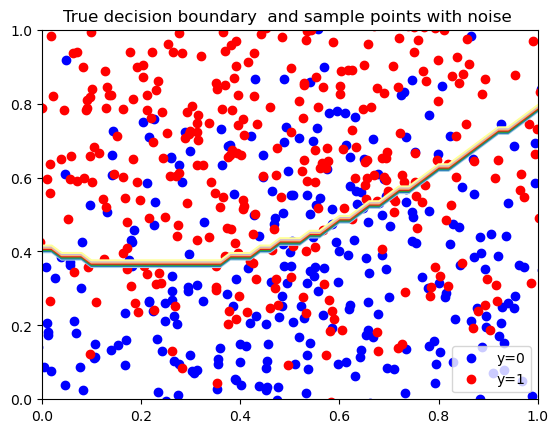

In [85]:
dataset = Data(noise_std=0.2)
dataset.plot()

In [86]:
torch.manual_seed(0)
validation_data = Data(train=False)

In [87]:
trainloader = DataLoader(dataset = dataset, batch_size=32)

### Create model, optimizer, loss function(cost):

In [88]:
# model with 1 hidden layer
class DropoutNet(nn.Module):
    def __init__(self, in_size, n_hidden, out_size, p = 0):
        super(DropoutNet, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        self.drop = nn.Dropout(p=p)
        
    def forward(self, x):
        x = self.drop(F.relu(self.linear1(x)))
        x = self.drop(F.relu(self.linear2(x)))
        x = self.linear3(x)
        return x

In [102]:
model = DropoutNet(2, 300, 2) # model without dropout
model_drop = DropoutNet(2, 300, 2, p=0.5) # model with dropout

In [103]:
# Setting the dropout model to training phase:
model_drop.train()

DropoutNet(
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [104]:
opti = torch.optim.Adam(model.parameters(), lr = 0.01)
opti_drop = torch.optim.Adam(model_drop.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [105]:
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['validation data dropout'] = []

### Training the model:

In [106]:
epochs = 500

def train_model(epochs):
    for epoch in range(epochs):
        if epoch%10==0:
            print(f"Training Epoch {epoch}/{epochs}...")
        yhat = model(dataset.x)
        yhat_drop = model_drop(dataset.x)
        loss = criterion(yhat, dataset.y)
        loss_drop = criterion(yhat_drop, dataset.y)
        
        #store the loss for both the training and validation data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_data.x), validation_data.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_data.x), validation_data.y).item())
        model_drop.train()
        
        opti.zero_grad()
        opti_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        opti.step()
        opti_drop.step()

In [107]:
train_model(epochs)

Training Epoch 0/500...
Training Epoch 10/500...
Training Epoch 20/500...
Training Epoch 30/500...
Training Epoch 40/500...
Training Epoch 50/500...
Training Epoch 60/500...
Training Epoch 70/500...
Training Epoch 80/500...
Training Epoch 90/500...
Training Epoch 100/500...
Training Epoch 110/500...
Training Epoch 120/500...
Training Epoch 130/500...
Training Epoch 140/500...
Training Epoch 150/500...
Training Epoch 160/500...
Training Epoch 170/500...
Training Epoch 180/500...
Training Epoch 190/500...
Training Epoch 200/500...
Training Epoch 210/500...
Training Epoch 220/500...
Training Epoch 230/500...
Training Epoch 240/500...
Training Epoch 250/500...
Training Epoch 260/500...
Training Epoch 270/500...
Training Epoch 280/500...
Training Epoch 290/500...
Training Epoch 300/500...
Training Epoch 310/500...
Training Epoch 320/500...
Training Epoch 330/500...
Training Epoch 340/500...
Training Epoch 350/500...
Training Epoch 360/500...
Training Epoch 370/500...
Training Epoch 380/500.

In [108]:
model_drop.eval()

DropoutNet(
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [109]:
# Print out the accuracy of the model without dropout

print("The accuracy of the model without dropout: ", accuracy(model, validation_data))

The accuracy of the model without dropout:  0.825


In [110]:
# Print out the accuracy of the model without dropout

print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_data))

The accuracy of the model with dropout:  0.848


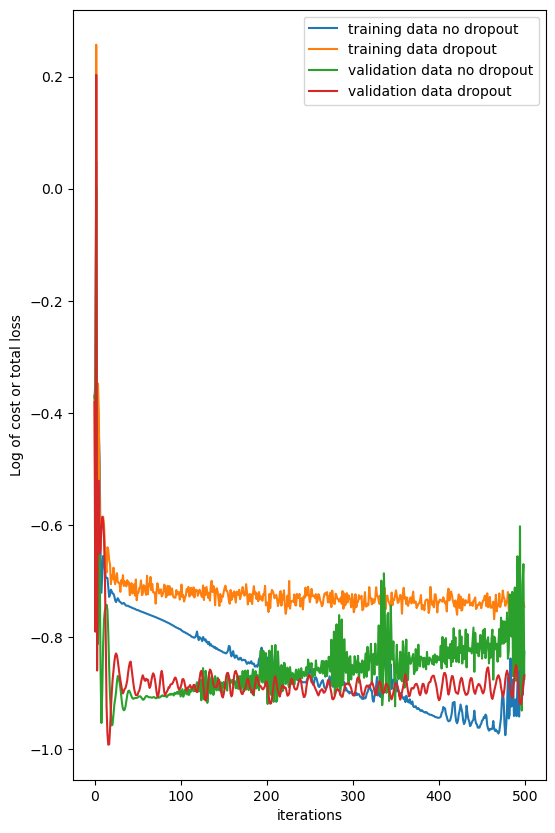

In [111]:
# Plot the LOSS

plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

## DNN with Dropout Regression:

In [112]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

In [115]:
class Data(Dataset):
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x**2
        if train!=True:
            torch.manual_seed(1)
            self.y = self.f + noise_std*torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
            
        else:
            self.y = self.f + noise_std*torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
        self.len = self.x.shape[0]
        
    def __getitem(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len
    
    def plot(self):
        plt.figure(figsize=(10,15))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy(), label = "True Function", color="orange")
        plt.xlabel("x")
        plt.ylabel("y")
#         plt.xlim((-1, 1))
#         plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

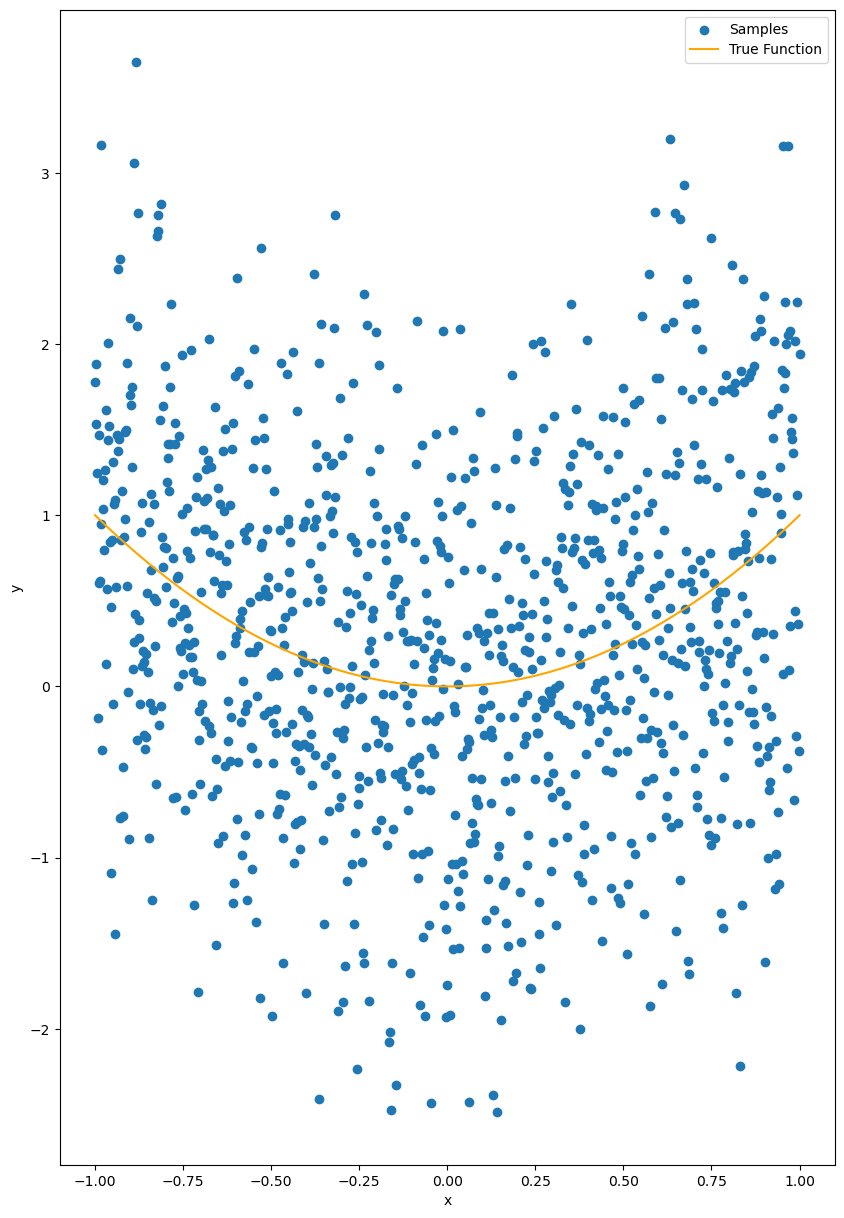

In [118]:
dataset = Data(N_SAMPLES=1000)
dataset.plot()

In [119]:
validation_set = Data(N_SAMPLES=200, train = False)

### Creating the model:

In [122]:
class Net(nn.Module):
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        self.drop = nn.Dropout(p=p)
        
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

In [123]:
model = Net(1, 300, 1)
model_drop = Net(1, 300, 1)

### Training the model using Mini-Batch Gradient Descent:

In [124]:
model_drop.train()

Net(
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
  (drop): Dropout(p=0, inplace=False)
)

In [ ]:
opti = optim.SGD()